# Learning a function with PyTorch

In this third lab of the **ErSE 222 - Machine Learning in Geoscience** course, we will teach a neural network to learn a function, e.g. $f(x)=sin(x)$. 

Based on the **Universal Approximation Theorem**, we know that a NN with one hidden layer can approximate any function. We however do not know how deep it should be and how good it is at generalization. We will see that even by making the network deep, we can quite accurately *interpolate* our function between points but we will do poorly when we try to *extrapolate* outside of the domain of the training data. This is a recurring theme in ML, and especially DL, so it is worth being aware of it and what better way than considering a numerical example.

Given enough pairs $(x,f(x))$ we wish the network to be able to give us a correct estimate of $f(x_i)$ on an unseen $x_i$.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader 
from torchsummary import summary

In [2]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

In [3]:
class DeepNetwork(nn.Module):
    def __init__(self, I, H, O):
        super(DeepNetwork, self).__init__()
        self.hidden_1 = nn.Linear(I, H[0], bias=True)
        self.hidden_2 = nn.Linear(H[0], H[1], bias=True)
        self.output = nn.Linear(H[1], O, bias=True)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        z1 = self.hidden_1(x)
        a1 = self.relu(z1)
        z2 = self.hidden_2(a1)
        a2 = self.relu(z2)
        z3 = self.output(a2)
        #a3 = self.tanh(z3)
        return z3

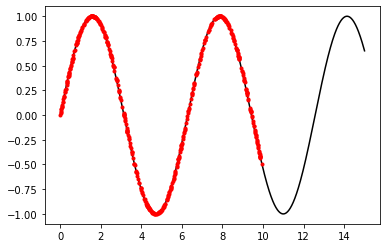

In [4]:
set_seed(5)

ntrain = 64*8
xtrain = torch.rand(ntrain) * 10

ntest = 1000
xtest = torch.linspace(0, 15, ntest)

ytrain = torch.sin(xtrain)
ytest = torch.sin(xtest)

plt.figure()
plt.plot(xtest, ytest, 'k')
plt.plot(xtrain, ytrain, '.r');

In [5]:
train_dataset = TensorDataset(xtrain, ytrain)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [6]:
model = DeepNetwork(1, [20, 50], 1)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.MSELoss()
n_epochs = 5000
loss_hist = []
for epoch in range(n_epochs):
    total_loss = 0.
    for X, y in train_loader:
        optimizer.zero_grad()
        yest = model(X.view(X.shape[0], 1)) 
        loss = criterion(yest, y.view(X.shape[0], 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    loss_hist.append(total_loss)
    if epoch % (n_epochs//10) == 0 and epoch > 0:
        print(f'''Epoch: {epoch}, Loss: {total_loss / X.size(0)}''')

Epoch: 500, Loss: 0.014503183541819453
Epoch: 1000, Loss: 0.0025839189474936575
Epoch: 1500, Loss: 0.00038032911652408075
Epoch: 2000, Loss: 0.0002715678383538034
Epoch: 2500, Loss: 0.00027755252631322946
Epoch: 3000, Loss: 7.82276083555189e-05
Epoch: 3500, Loss: 8.306534164148616e-05
Epoch: 4000, Loss: 0.0001335957945229893
Epoch: 4500, Loss: 6.696711579934345e-05


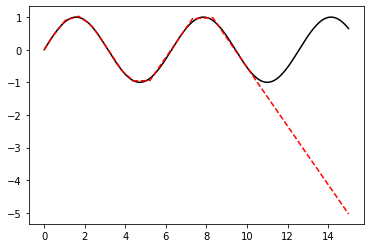

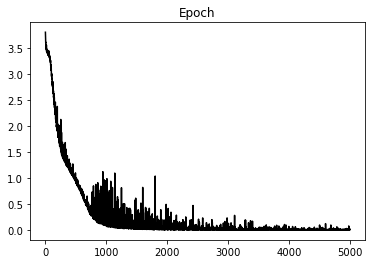

In [7]:
ypred = model(xtest.view(xtest.shape[0], 1)) 

plt.figure()
plt.plot(xtest, ytest, 'k')
plt.plot(xtest, ypred.detach().numpy(), '--r')

plt.figure()
plt.plot(loss_hist, 'k')
plt.title('Epoch');